In [3]:
import sys
import os
sys.path.append(os.path.abspath(".."))
import numpy as np

In [4]:
def rgb_2_hsv(image:np.array):
    # image = cv2.imread(image_path)
    # BGR2RGB
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # RGB2HSV
    image = image / 255.0
    hsv = np.zeros_like(image)
    max_val = np.max(image, axis=2)
    min_val = np.min(image, axis=2)
    delta = max_val - min_val
    # H
    hsv[..., 0] = np.where(max_val == min_val, 0,
                            np.where(max_val == image[..., 0], 60 * (image[..., 1] - image[..., 2]) / delta,
                                     np.where(max_val == image[..., 1], 60 * (image[..., 2] - image[..., 0]) / delta + 120,
                                              60 * (image[..., 0] - image[..., 1]) / delta + 240)))
    hsv[..., 0] = (hsv[..., 0] + 360) % 360
    # S
    hsv[..., 1] = np.where(max_val == 0, 0, delta / max_val)
    # V
    hsv[..., 2] = max_val
    return hsv

C:\Users\86182\AppData\Local\Temp\ipykernel_8512\877714709.py:13: RuntimeWarning: invalid value encountered in divide
  np.where(max_val == image[..., 0], 60 * (image[..., 1] - image[..., 2]) / delta,
C:\Users\86182\AppData\Local\Temp\ipykernel_8512\877714709.py:14: RuntimeWarning: invalid value encountered in divide
  np.where(max_val == image[..., 1], 60 * (image[..., 2] - image[..., 0]) / delta + 120,
C:\Users\86182\AppData\Local\Temp\ipykernel_8512\877714709.py:15: RuntimeWarning: invalid value encountered in divide
  60 * (image[..., 0] - image[..., 1]) / delta + 240)))
C:\Users\86182\AppData\Local\Temp\ipykernel_8512\877714709.py:18: RuntimeWarning: invalid value encountered in divide
  hsv[..., 1] = np.where(max_val == 0, 0, delta / max_val)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..356.0].


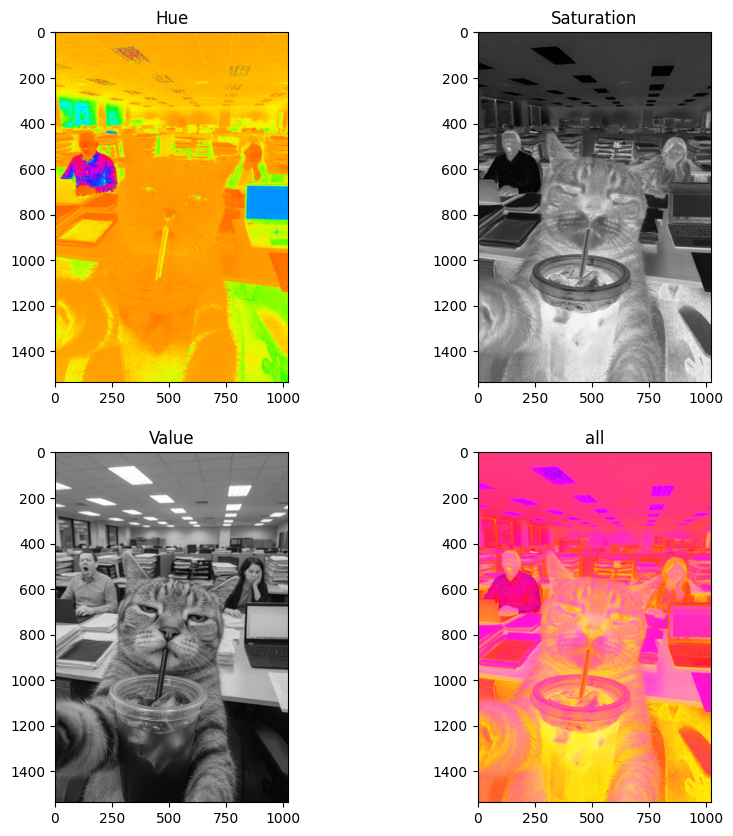

In [5]:
from PIL import Image
import matplotlib.pyplot as plt
from src.utils import get_data_path

img_path=get_data_path('test_img.png')
img=np.array(Image.open(img_path))
hsv=rgb_2_hsv(image=img)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# H 通道（色调，转到[0,1]范围显示）
axs[0][0].imshow(hsv[...,0] / 360.0, cmap="hsv")
axs[0][0].set_title("Hue")

# S 通道
axs[0][1].imshow(hsv[...,1], cmap="gray")
axs[0][1].set_title("Saturation")

# V 通道
axs[1][0].imshow(hsv[...,2], cmap="gray")
axs[1][0].set_title("Value")

# all
axs[1][1].imshow(hsv)
axs[1][1].set_title("all")


plt.show()


##### RGB-2-YCbCr

In [6]:
def rgb_to_ycbcr(img_rgb, out_dtype=np.uint8):
    # 统一到 float64，按范围归一到[0,1]
    x = img_rgb.astype(np.float64)
    if x.max() > 1.0:   # 认为是[0,255]
        x /= 255.0

    R, G, B = x[..., 0], x[..., 1], x[..., 2]

    # JPEG/BT.601 full-range 系数
    Y  = 0.299    * R + 0.587    * G + 0.114    * B
    Cb = -0.168736* R - 0.331264 * G + 0.5      * B + 0.5  # +128/255
    Cr = 0.5      * R - 0.418688 * G - 0.081312 * B + 0.5  # +128/255

    ycbcr = np.stack([Y, Cb, Cr], axis=-1)

    if out_dtype == np.uint8:
        ycbcr = np.clip(np.round(ycbcr * 255.0), 0, 255).astype(np.uint8)
    else:
        ycbcr = np.clip(ycbcr, 0.0, 1.0).astype(out_dtype)
    return ycbcr

def ycbcr_to_rgb(img_ycbcr, out_dtype=np.uint8):
    ycbcr = img_ycbcr.astype(np.float64)
    if ycbcr.max() > 1.0:   # 认为是[0,255]
        ycbcr /= 255.0

    Y  = ycbcr[..., 0]
    Cb = ycbcr[..., 1] - 0.5  # -128/255
    Cr = ycbcr[..., 2] - 0.5

    # 逆变换（JPEG/BT.601 full-range）
    R = Y + 1.402   * Cr
    G = Y - 0.344136* Cb - 0.714136* Cr
    B = Y + 1.772   * Cb

    rgb = np.stack([R, G, B], axis=-1)

    if out_dtype == np.uint8:
        rgb = np.clip(np.round(rgb * 255.0), 0, 255).astype(np.uint8)
    else:
        rgb = np.clip(rgb, 0.0, 1.0).astype(out_dtype)
    return rgb

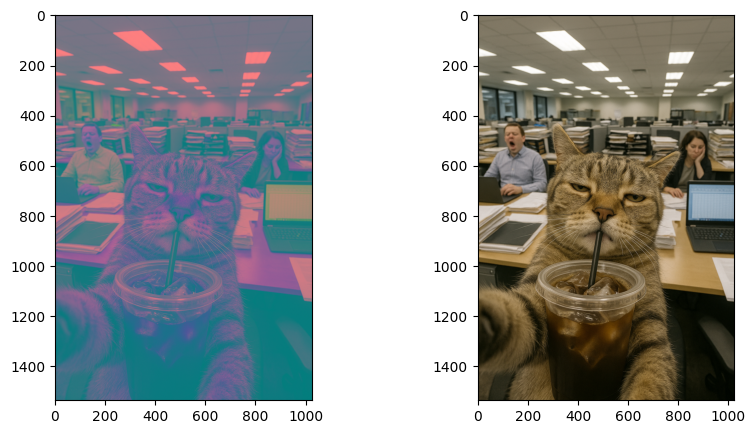

In [7]:
ycbcr = rgb_to_ycbcr(img, out_dtype=np.uint8)
ycbcr_rgb_back=ycbcr_to_rgb(ycbcr,out_dtype=np.uint8)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(ycbcr)
axs[1].imshow(ycbcr_rgb_back)
plt.show()

##### RGB-2-CMYK

In [8]:
def _to_float01(x: np.ndarray) -> np.ndarray:
    x = x.astype(np.float64)
    if x.max() > 1.0:     # 认为是 uint8 0..255
        x /= 255.0
    return x

# ========== RGB -> CMYK ==========
# 输入:  img_rgb: (H,W,3)  dtype 可为 uint8(0..255) 或 float(0..1)
# 输出:  (H,W,4)  依 out_dtype 返回 0..255 或 0..1
def rgb_to_cmyk(img_rgb: np.ndarray, out_dtype=np.uint8, eps: float = 1e-10) -> np.ndarray:
    x = _to_float01(img_rgb)
    R, G, B = x[..., 0], x[..., 1], x[..., 2]

    K = 1.0 - np.maximum.reduce([R, G, B])
    denom = 1.0 - K + eps  # 防止除零

    C = (1.0 - R - K) / denom
    M = (1.0 - G - K) / denom
    Y = (1.0 - B - K) / denom

    # 当 K=1 (纯黑) 时，定义 C=M=Y=0
    mask_black = (K >= 1.0 - eps)
    C[mask_black] = 0.0
    M[mask_black] = 0.0
    Y[mask_black] = 0.0

    cmyk = np.stack([C, M, Y, K], axis=-1)

    if out_dtype == np.uint8:
        return np.clip(np.round(cmyk * 255.0), 0, 255).astype(np.uint8)
    else:
        return np.clip(cmyk, 0.0, 1.0).astype(out_dtype)


# ========== CMYK -> RGB（可选，便于验证） ==========
# 输入:  img_cmyk: (H,W,4)  dtype 可为 uint8(0..255) 或 float(0..1)
# 输出:  (H,W,3)  依 out_dtype 返回 0..255 或 0..1
def cmyk_to_rgb(img_cmyk: np.ndarray, out_dtype=np.uint8) -> np.ndarray:
    cmyk = img_cmyk.astype(np.float64)
    if cmyk.max() > 1.0:
        cmyk /= 255.0

    C, M, Y, K = cmyk[..., 0], cmyk[..., 1], cmyk[..., 2], cmyk[..., 3]
    R = (1.0 - C) * (1.0 - K)
    G = (1.0 - M) * (1.0 - K)
    B = (1.0 - Y) * (1.0 - K)

    rgb = np.stack([R, G, B], axis=-1)

    if out_dtype == np.uint8:
        return np.clip(np.round(rgb * 255.0), 0, 255).astype(np.uint8)
    else:
        return np.clip(rgb, 0.0, 1.0).astype(out_dtype)

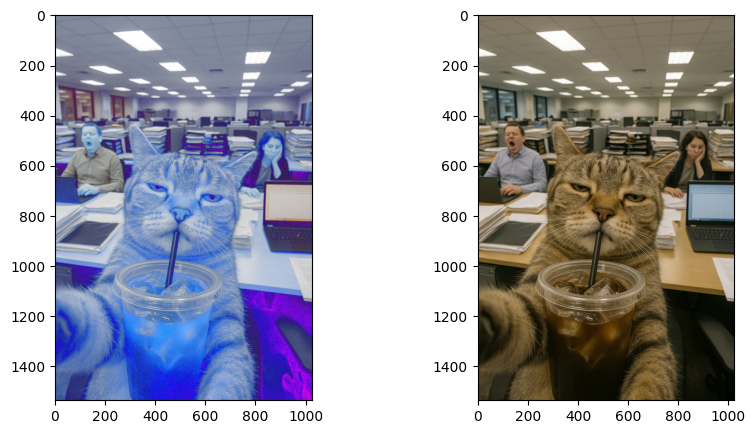

In [9]:
cmyk = rgb_to_cmyk(img, out_dtype=np.uint8)
rgb_back = cmyk_to_rgb(cmyk, out_dtype=np.uint8)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(cmyk)
axs[1].imshow(rgb_back)
plt.show()

##### Generate few sample images 

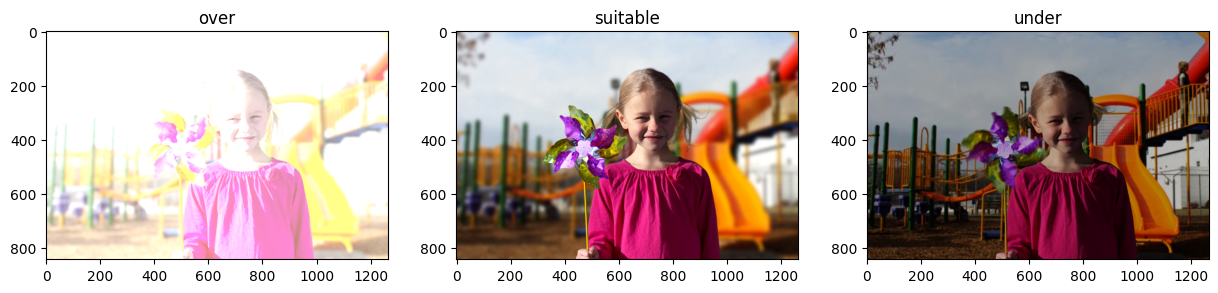

In [11]:
over_img=Image.open(r"C:\Users\86182\Desktop\over.png")
suitable_img=Image.open(r"C:\Users\86182\Desktop\suitable.png")
under_img=Image.open(r"C:\Users\86182\Desktop\under.png")

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(over_img)
axs[0].set_title("over")

axs[1].imshow(suitable_img)
axs[1].set_title("suitable")

axs[2].imshow(under_img)
axs[2].set_title("under")

plt.show()